In [1]:
# In the presentation we want unsatisfied consumption with: rerouting, uncapacitated, assignment 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
plt.style.use(["science","grid"])
def normalise(arr):
    arrmax = np.max(arr)
    arrmin = np.min(arr)
    
    arrnorm = (arr - arrmin) / (arrmax - arrmin)
    
    return arrnorm
def ticks_labels(nb_days):
    if 30%nb_days != 0:
        raise ValueError 
    else:
        vec = np.linspace(0,4320,int(30/nb_days)+1)
        labs = list()
        for i in range(int(30/nb_days)+1):
            labs.append("Day %s"%(i*nb_days))
        return vec,labs

In [3]:
data_rerouting = pd.read_feather("./rerouting30/rerouting30")
input_vars_rerouting = pd.read_csv("./rerouting30/input_parameters_rerouting30.csv")

data_capacity = pd.read_feather("./capacity/capacity30")
input_vars_capacity = pd.read_csv("./capacity/input_parameters_capacity30.csv")

data_capacity.o0 = data_capacity.o0 + len(input_vars_rerouting)
input_vars_capacity.index = input_vars_capacity.index + len(input_vars_rerouting)

data = pd.concat([data_rerouting,data_capacity])
input_vars = pd.concat([input_vars_rerouting,input_vars_capacity])

In [4]:
# q_sum = list()
# n_facs = 12
# for j in input_vars.index:
#     tmp_sum = 0
#     for i in range(n_facs):
#         tmp_sum += ( np.sum(data[data.o0==j].iloc[:,i+4]))  
    
#     q_sum.append(tmp_sum)    

uc_endvals_dict = {}
for i in ["unsatisfied consumption","policy type","variation"]:#,"allfacs"]:#,"fac5","food waste","distance"]:
    uc_endvals_dict[i] = list()


for j in input_vars.index:
    uc_endvals_dict["unsatisfied consumption"].append(data.o1[data.o0==j].iloc[-1])
#     uc_endvals_dict["food waste"].append(data.o2[data.o0==j].iloc[-1])
#     uc_endvals_dict["distance"].append(data.o3[data.o0==j].iloc[-1])
#     uc_endvals_dict["fac5"].append( np.sum(data[data.o0==j].iloc[:,9]))
#     uc_endvals_dict["allfacs"].append( q_sum[j] )

    if input_vars.capacity_policy[j] > 0:
        uc_endvals_dict["policy type"].append(1)
        uc_endvals_dict["variation"].append(input_vars.capacity_policy[j])
    elif input_vars.rerouting_policy[j] > 0:
        uc_endvals_dict["policy type"].append(2)
        uc_endvals_dict["variation"].append(input_vars.rerouting_policy[j]+2)
    else:
        uc_endvals_dict["policy type"].append(0)
        uc_endvals_dict["variation"].append(0)    

uc_endvals_df = pd.DataFrame(uc_endvals_dict)
input_vars_filtered = pd.concat([input_vars,uc_endvals_df],axis=1)

In [5]:
factor_names = ["alpha","beta","gamma","epsilon","parallel_served_full"]

scenarios = np.array([ [1.0, 0.0, 7.0, 0.1, 6.0], # No social interaction; low visiting frequency
              [0.0, 1.0, 7.0, 0.1, 6.0],
              [0.0, 1.0, 7.0, 1.0, 6.0], # Social interaction; low visiting frequency
              [0.0, 1.0, 3.0, 0.1, 7.8], # Social interaction; high visiting frequency
              [1.0, 0.0, 3.0, 0.1, 7.8]]) # Particular to capacity analysis icm queuing

In [6]:
# Indices of relevant scenarios 
relevant_indices = [0,1,3,4]
relevant_scenarios = scenarios[ relevant_indices ]

# Modify DF for plot; Label scenarios
storage_EoR = {}
storage_TS = {}

for s in range(len(relevant_scenarios)):
       
    tmp_EoR = input_vars_filtered
    
    # Select scenario
    for f in range(len(factor_names)):
        tmp_EoR = tmp_EoR[ tmp_EoR[factor_names[f]] == relevant_scenarios[s][f] ]
    
    print(len(tmp_EoR))
    tmp_TS = data[data.o0.isin(tmp_EoR.index)]
    
    # Label that scenario

    scenario_col = np.ones(len(tmp_EoR)*4320)*s    
    variation_col = list()
    timestep_col = list()
    
    for i in tmp_EoR.index:
        variation_col +=  list(np.ones(4320)*tmp_EoR["variation"][i])
        timestep_col += list(np.linspace(0,4319,4320))
        
    tmp_TS = pd.concat([tmp_TS.reset_index(),pd.DataFrame({"scenario":np.ones(len(tmp_EoR)*4320)*s , "variation":variation_col , "timestep":timestep_col })],axis=1)

    tmp_EoR = pd.concat([tmp_EoR.reset_index(),pd.DataFrame({"scenario":np.ones(len(tmp_EoR))*s})],axis=1)

    
    # Store in temporary storage dict 
    storage_TS[s] = tmp_TS
    storage_EoR[s] = tmp_EoR

70
70
70
70


### Timeseries

<ipython-input-7-f60a38f1ca49>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot_selector[scenario].set_yticklabels(np.linspace(0,90,10),fontsize=15)
<ipython-input-7-f60a38f1ca49>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot_selector[scenario].set_yticklabels(np.linspace(0,90,10),fontsize=15)
<ipython-input-7-f60a38f1ca49>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot_selector[scenario].set_yticklabels(np.linspace(0,90,10),fontsize=15)
<ipython-input-7-f60a38f1ca49>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  subplot_selector[scenario].set_yticklabels(np.linspace(0,90,10),fontsize=15)


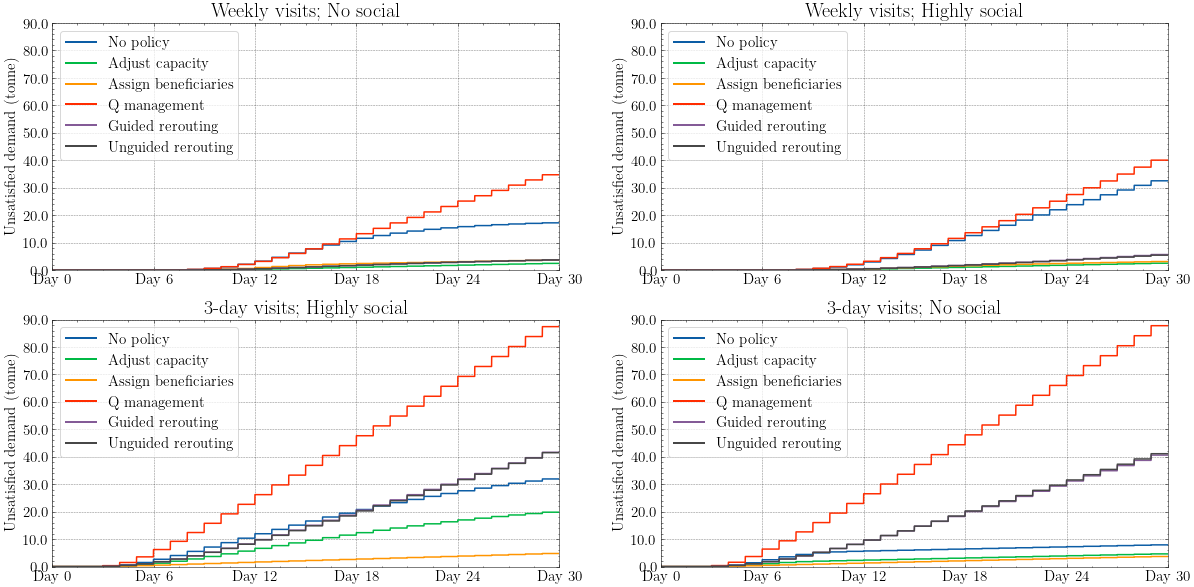

In [7]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

lineplot_df = pd.concat(storage_TS.values())

subplot_selector = { 0: ax[0,0], 
                     1: ax[0,1],
                     2: ax[1,0],
                     3: ax[1,1]}

titles = ["Weekly visits; No social","Weekly visits; Highly social","3-day visits; Highly social","3-day visits; No social",]


for scenario in [0,1,2,3]:
    
    selected_for_scenario = lineplot_df[lineplot_df["scenario"]==scenario].groupby(["timestep","variation"]).mean()
    to_plot = pd.DataFrame(pd.pivot_table(pd.DataFrame(selected_for_scenario["o1"]), columns=['variation'], index='timestep').values)

    sns.lineplot(ax=subplot_selector[scenario],data=to_plot,dashes=False,linewidth=1.5) 
    
#     Further makeup
    subplot_selector[scenario].set_title(titles[scenario],fontsize=20)
    subplot_selector[scenario].set_ylim([0,90e3])
    subplot_selector[scenario].set_yticklabels(np.linspace(0,90,10),fontsize=15)
    subplot_selector[scenario].set_ylabel("Unsatisfied demand (tonne)",fontsize=15)

    subplot_selector[scenario].set_xlim([0,4320])
    subplot_selector[scenario].set_xticks(ticks = ticks_labels(6)[0])
    subplot_selector[scenario].set_xticklabels(ticks_labels(6)[1],fontsize=15)
    
    # legend
    handles = subplot_selector[scenario].get_legend_handles_labels()[0]
    [ha.set_linewidth(2) for ha in handles ]
    labels = ["No policy","Adjust capacity","Assign beneficiaries","Q management","Guided rerouting", "Unguided rerouting"]
    subplot_selector[scenario].legend(handles[:6],labels,loc='upper left',fontsize=15,framealpha=0.75)

### End of run 

<ipython-input-8-325a1abaa7db>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.linspace(0,100,6),fontsize=28)


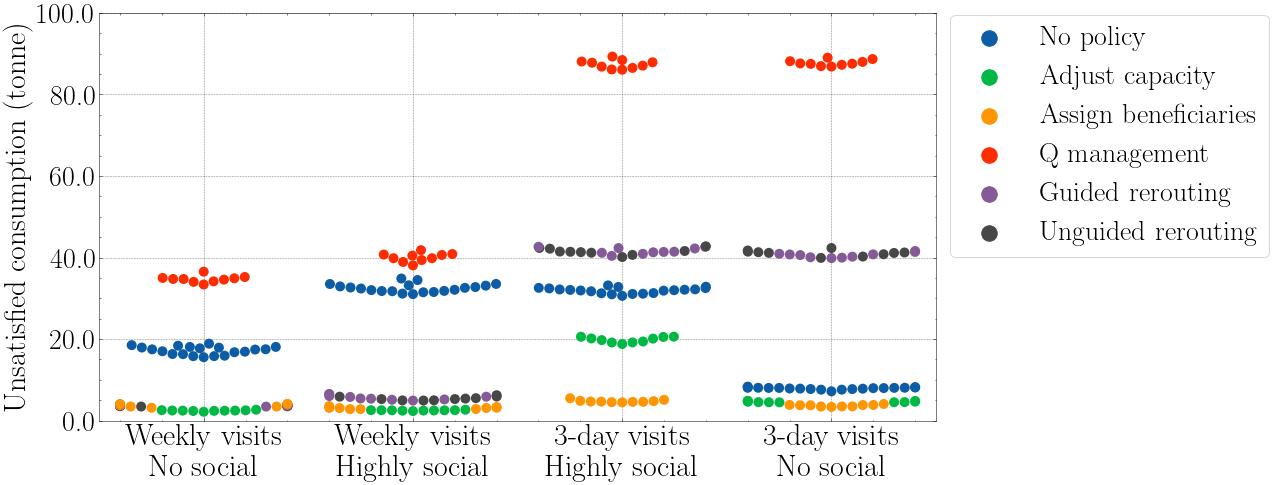

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,7.5))

# Create swarmplot
sns.swarmplot(ax=ax, x='scenario', hue='variation', y="unsatisfied consumption", data=pd.concat(storage_EoR.values()), size=10,)

# x-axis
ax.set_xlabel(None)
xticklabels = ["Scenario %s"%(i+1) for i in relevant_indices]
xticklabels = ["Weekly visits\nNo social","Weekly visits\nHighly social","3-day visits\nHighly social","3-day visits\nNo social",]
ax.set_xticklabels(xticklabels,fontsize=30)

# y-axis
ax.set_ylim([0,100e3])
ax.set_yticklabels(np.linspace(0,100,6),fontsize=28)
ax.set_ylabel("Unsatisfied consumption (tonne)",fontsize=30)

# grid
ax.yaxis.grid(True) # Hide the horizontal gridlines
ax.xaxis.grid(True) # Show the vertical gridlines

# legend
handles = ax.get_legend_handles_labels()[0]
labels = ["No policy","Adjust capacity","Assign beneficiaries","Q management","Guided rerouting", "Unguided rerouting"]
ax.legend(handles[:6],labels,loc='upper left',fontsize=28,markerscale=2,bbox_to_anchor=(1.0, 1.03),framealpha=0.75);

# plt.savefig("/home/daan/Desktop/Presentation_results.png")

### Heatmap with End-of-Run cumulative unsatisfied demand 

In [96]:
sortedDF = pd.concat(storage_EoR.values()).groupby(["variation","scenario"]).mean()
dryValues = pd.pivot_table(pd.DataFrame(sortedDF["unsatisfied consumption"]), index=['variation'], columns='scenario').values

"""
Variations
0: No policy, capacitated, in a way
1: Capacity, uncapacitated
2: Capacity, assign beneficiaries

1+2: Rerouting, queue management
2+2: Random facility to spread demand
2+3: Closest facility
"""

xticklabels = ["Weekly visits\nNo social","Weekly visits\nHighly social","3-day visits\nHighly social","3-day visits\nNo social",]
yticklabels = ["No policy","Adjust capacity","Assign beneficiaries","Q management","Guided rerouting", "Unguided rerouting"]

# Matrix for interval annotations
minmax = pd.concat(storage_EoR.values()).groupby(["variation","scenario"]).agg(['min','max'])
dryValuesminmax = pd.pivot_table(pd.DataFrame(minmax["unsatisfied consumption"]), index=['variation'], columns='scenario').values

labels=[]
for rowi in range(6):
    labels.append([])
    for coli in range(4):
        labels[rowi].append(  str( np.round(dryValuesminmax[rowi,coli+4]/1000,1) ) + '-'+ str( np.round(dryValuesminmax[rowi,coli]/1000,1) ) )    

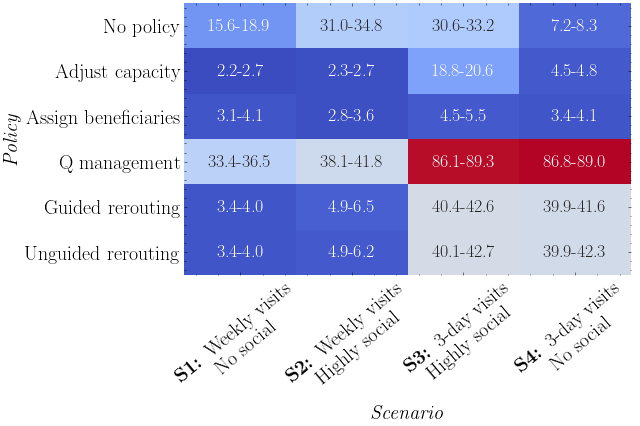

In [97]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
sns.heatmap(np.round(dryValues/1000.),ax=ax, annot=labels, cmap='coolwarm',fmt = '',annot_kws={"fontsize":18});
ax.set_xlabel("$\it{Scenario}$",size=20)
ax.set_ylabel("$\it{Policy}$",size=20)
plt.yticks(rotation=0) 

for i in range(4):
    xticklabels[i] = r'$\textbf{S%s: }$'%(i+1)+xticklabels[i]

ax.set_yticklabels(yticklabels,fontsize=20,)
ax.set_xticklabels(xticklabels,fontsize=20,rotation=40)

fig.axes[1].set_visible(False)
plt.savefig("/home/daan/Dropbox/Werk/Paper_figures/heatmap_ranges.png",dpi=300,bbox_inches = 'tight')

In [84]:
xticklabels

['Weekly visits\nNo social',
 'Weekly visits\nHighly social',
 '3-day visits\nHighly social',
 '3-day visits\nNo social']

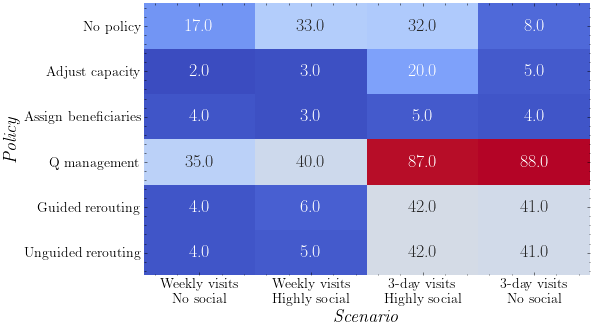

In [11]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
sns.heatmap(np.round(dryValues/1000.),ax=ax, annot=True, cmap='coolwarm',fmt = '',annot_kws={"fontsize":18});
ax.set_xlabel("$\it{Scenario}$",size=18)
ax.set_ylabel("$\it{Policy}$",size=18)
plt.yticks(rotation=0) 

ax.set_yticklabels(yticklabels,fontsize=14)
ax.set_xticklabels(xticklabels,fontsize=14)

fig.axes[1].set_visible(False)

### Pressing the play button: anxiety and unsatisfied demand 

In [12]:
# reading the only model outcomes with 
ES_input_vars = pd.read_csv("validation/input_parameters_validation.csv")
ES_data = pd.read_feather("validation/validation")

ES_input_vars = ES_input_vars[ES_input_vars.ration_size_policy == 30]
ES_input_vars = ES_input_vars[ES_input_vars.facility_refill_frequency == 1.0]

ES_data = ES_data[ES_data.o0.isin(ES_input_vars.index)].reset_index().rename(columns={'index':'timestep'})
ES_data["timestep"]=ES_data["timestep"]%4320

# Making long dataset allowing for confidence interval
ES_data_long = ES_data.pivot(index='timestep',columns='o0',values=['o1','o5']).stack().reset_index()
ES_data_long.columns=['timestep','replication','UD','ES']

ES_data_short = ES_data.groupby(["timestep"]).mean()

/home/daan/miniconda3/lib/python3.8/site-packages/seaborn/relational.py:913: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scout = ax.scatter([], [], **kws)
/home/daan/miniconda3/lib/python3.8/site-packages/seaborn/relational.py:950: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


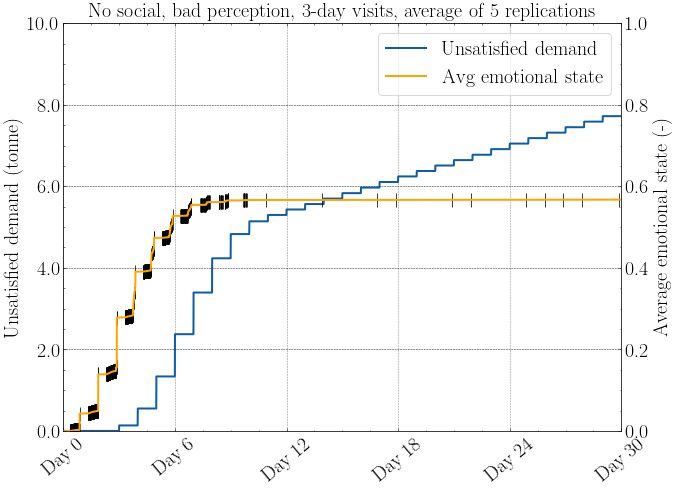

In [70]:
fig, ax = plt.subplots(1,1,figsize=(10,7.5))

# Second y-axis
ax2 = plt.twinx()

# Plot 
ln1 = sns.lineplot(ax=ax,data=ES_data_short["o1"],linewidth=2,label='Unsatisfied demand').set_title("No social, bad perception, 3-day visits, average of 5 replications",size=20)
sns.scatterplot(ax=ax2, data = ES_data_short["o5"][[False]+[ES_data_short["o5"][i] != ES_data_short["o5"][i-1] for i in range(1,len(ES_data_short))]],s=200,marker="|",color='black',edgecolor='black')

ln2 = sns.lineplot(ax=ax2,data=ES_data_short["o5"],linewidth=2,color='orange',label='Avg emotional state')

# Set up left y-axis
ax.set_ylim([0,8e3])
ax.set_ylabel("Unsatisfied demand (tonne)",fontsize=20)
ax.set_yticks(np.linspace(0e3,10e3,6))
ax.set_yticklabels(np.linspace(0,10,6),fontsize=20)

# Set up right y-axis
ax2.set_ylim([0,0.6])
ax2.set_ylabel("Average emotional state (-)",fontsize=20)
ax2.set_ylim([0,1.0])
ax2.set_yticks(np.linspace(0,1.0,6))
ax2.set_yticklabels(np.round(np.linspace(0,1.0,6),1),size=20)

ax.set_xticks(ticks = ticks_labels(6)[0])
ax.set_xticklabels(ticks_labels(6)[1],size=20,rotation=40)
ax.set_xlim([0,4320])

handles = ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0] 
# [ha.set_linewidth(2) for ha in handles ]
labels= ['Unsatisfied demand','Avg emotional state']
ax2.legend(handles[:2],labels,loc='upper right',fontsize=20,framealpha=0.75)
ax.get_legend().remove()

plt.savefig("/home/daan/Dropbox/Werk/Paper_figures/UCvsES.png",dpi=300,bbox_inches = 'tight')

/home/daan/miniconda3/lib/python3.8/site-packages/seaborn/relational.py:950: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
<ipython-input-61-2b2aa298005a>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(np.linspace(0,1.0,6),1),size=20)


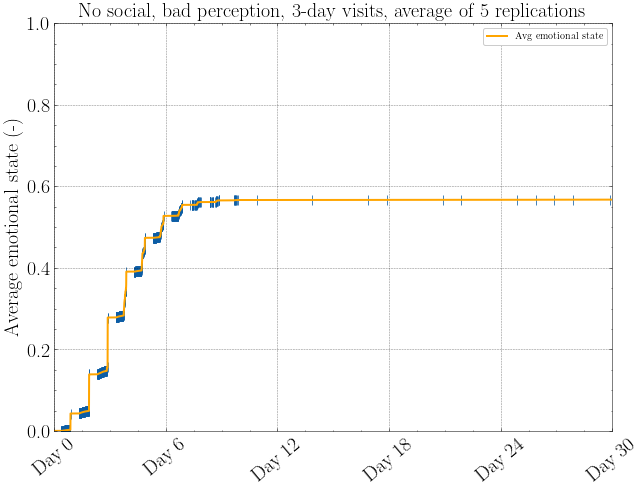

In [61]:
fig, ax = plt.subplots(1,1,figsize=(10,7.5))

# Plot 
sns.scatterplot(ax=ax, data = ES_data_short["o5"][[False]+[ES_data_short["o5"][i] != ES_data_short["o5"][i-1] for i in range(1,len(ES_data_short))]],s=100,marker="|")

sns.lineplot(ax=ax,data=ES_data_short["o5"],linewidth=2,color='orange',label='Avg emotional state').set_title("No social, bad perception, 3-day visits, average of 5 replications",size=20)



# Set up right y-axis
ax.set_ylim([0,0.6])
ax.set_ylabel("Average emotional state (-)",fontsize=20)
ax.set_ylim([0,1.0])
ax.set_yticklabels(np.round(np.linspace(0,1.0,6),1),size=20)

ax.set_xticks(ticks = ticks_labels(6)[0])
ax.set_xticklabels(ticks_labels(6)[1],size=20,rotation=40)
ax.set_xlim([0,4320])

handles = ax.get_legend_handles_labels()[0] 
# [ha.set_linewidth(2) for ha in handles ]
labels= ['Unsatisfied demand','Avg emotional state']

# plt.savefig("/home/daan/Dropbox/Werk/Paper_figures/UCvsES.png",dpi=300,bbox_inches = 'tight')

<ipython-input-14-973ded10d600>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[index].set_yticklabels(np.linspace(0,250,6),fontsize=20)
<ipython-input-14-973ded10d600>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[index].set_yticklabels(np.linspace(0,250,6),fontsize=20)


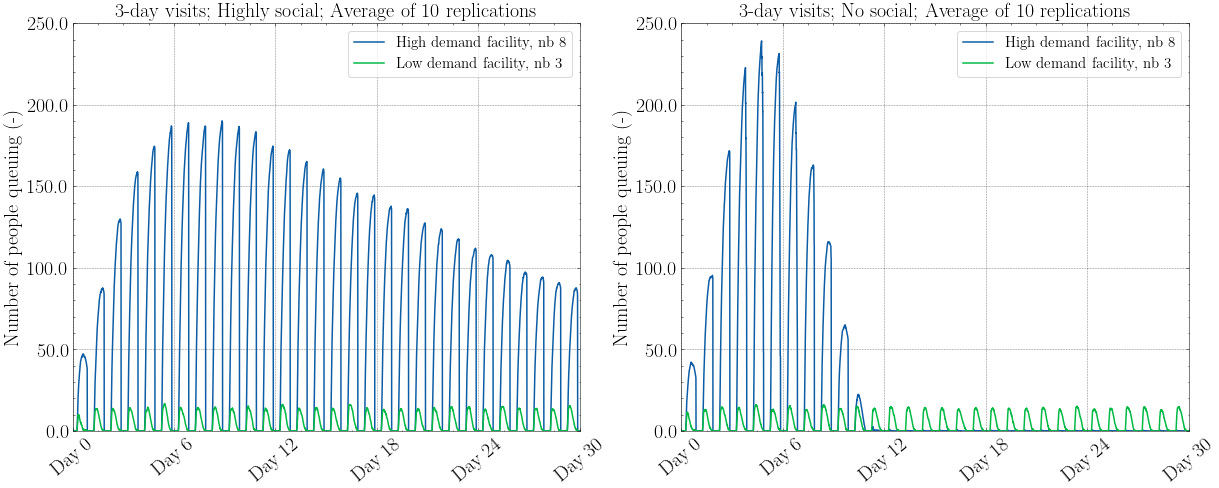

In [14]:
fig, ax = plt.subplots(1,2,figsize=(20,7.5))

lineplot_df = pd.concat(storage_TS.values())
lineplot_df = lineplot_df[lineplot_df["variation"]==0]
lineplot_df.rename({"index":"timestep"})

titles = ["Weekly visits; No social","Weekly visits; Highly social","3-day visits; Highly social","3-day visits; No social",]


for scenario in [2,3]:#,2,3]:
    
    index = scenario-2
    
    lineplot_df = pd.concat(storage_TS.values())
    lineplot_df = lineplot_df[lineplot_df["variation"]==0]
    to_plot = lineplot_df[lineplot_df["scenario"]==scenario].groupby(["timestep"]).mean()

#     sns.lineplot(ax=ax[scenario],data=to_plot,dashes=False,linewidth=1.5) 
    sns.lineplot(ax=ax[index],data=to_plot["o12"],dashes=False,linewidth=1.5,legend='full', label='High demand facility, nb 8') 
    sns.lineplot(ax=ax[index],data=to_plot["o7"],dashes=False,linewidth=1.5,legend='full',label='Low demand facility, nb 3') 

#     Further makeup
    ax[index].set_title(titles[scenario]+"; Average of 10 replications",fontsize=20)
    ax[index].set_ylim([0,250])
    ax[index].set_yticklabels(np.linspace(0,250,6),fontsize=20)
    ax[index].set_ylabel("Number of people queuing (-)",fontsize=20)

    ax[index].set_xlim([0,4320])
    ax[index].set_xticks(ticks = ticks_labels(6)[0])
    ax[index].set_xticklabels(ticks_labels(6)[1],fontsize=20,rotation=40)

for a in ax:
    handles = a.get_legend_handles_labels()[0]
    # [ha.set_linewidth(2) for ha in handles ]
    labels= ['High demand facility, nb 8', 'Low demand facility, nb 3']
    a.legend(handles[:2],labels,loc='upper right',fontsize=15,framealpha=0.75)
plt.savefig("/home/daan/Dropbox/Werk/Paper_figures/queuing_fac8n3.png",dpi=300,bbox_inches = 'tight')

### Analysis per facility for No policy base case

Plotting scenarios  3-day visits; Highly social  and  3-day visits; No social


<ipython-input-98-7e259f5914ae>:19: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  a.set_ylim([0,np.ceil( np.max([ np.max(to_plot_dict[0]["o%s"%(i+4)]) , np.max(to_plot_dict[1]["o%s"%(i+4)]) ]) )])


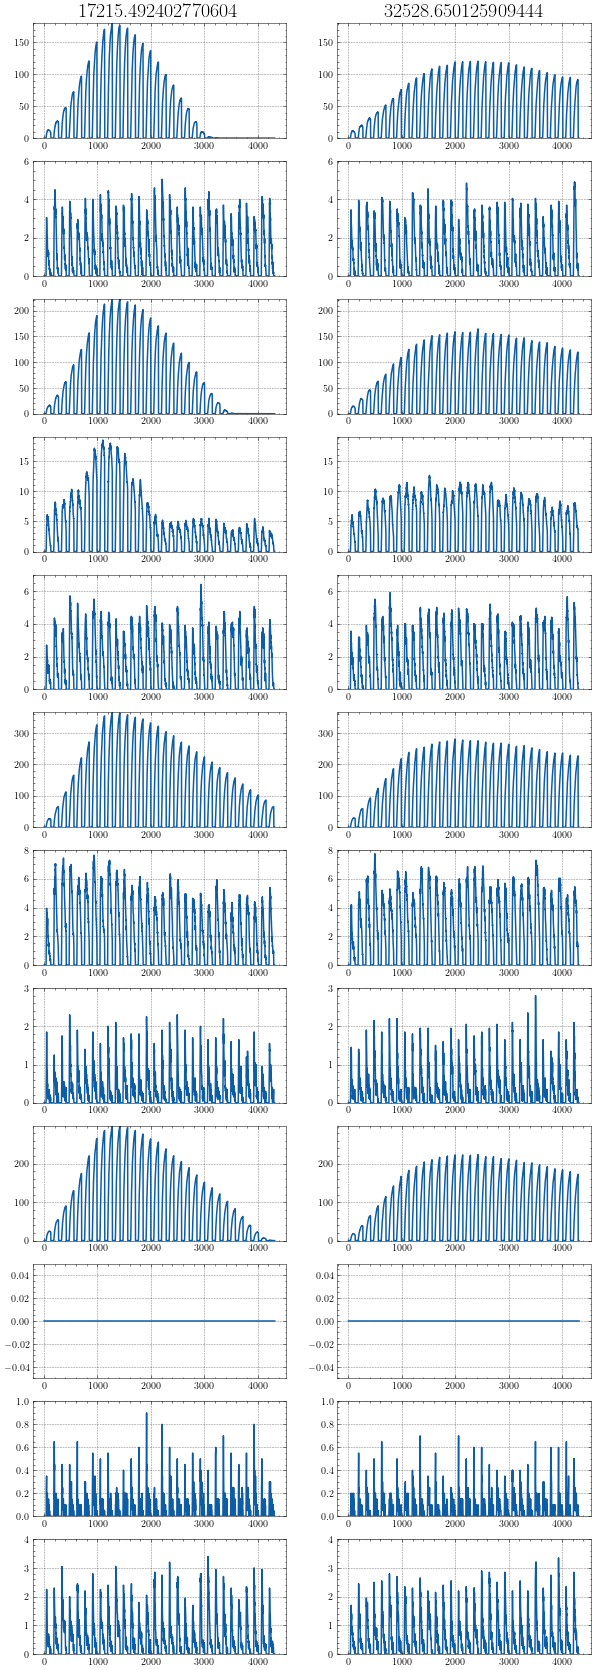

In [98]:
fig, ax = plt.subplots(12,2,figsize=(10,30))

lineplot_df = pd.concat(storage_TS.values())
lineplot_df = lineplot_df[lineplot_df["variation"]==0]
lineplot_df.rename({"index":"timestep"})

titles = ["Weekly visits; No social","Weekly visits; Highly social","3-day visits; Highly social","3-day visits; No social",]

print("Plotting scenarios ",titles[2]," and ",titles[3])

to_plot_dict = {0:lineplot_df[lineplot_df["scenario"]==0].groupby(["timestep"]).mean() ,
                1: lineplot_df[lineplot_df["scenario"]==1].groupby(["timestep"]).mean() }
    
for i in range(12):
    sns.lineplot(ax=ax[i,0],data=to_plot_dict[0]["o%s"%(i+4)],dashes=False,linewidth=1.5) 
    sns.lineplot(ax=ax[i,1],data=to_plot_dict[1]["o%s"%(i+4)],dashes=False,linewidth=1.5) 
    
    for a in ax[i,:]:
        a.set_ylim([0,np.ceil( np.max([ np.max(to_plot_dict[0]["o%s"%(i+4)]) , np.max(to_plot_dict[1]["o%s"%(i+4)]) ]) )])
        
for i in range(2):
    ax[0,i].set_title(to_plot_dict[i].iloc[-1,2],fontsize=20)


### Analysis of queuing per facility 

Plotting scenarios  Weekly visits; No social  and  Weekly visits; Highly social


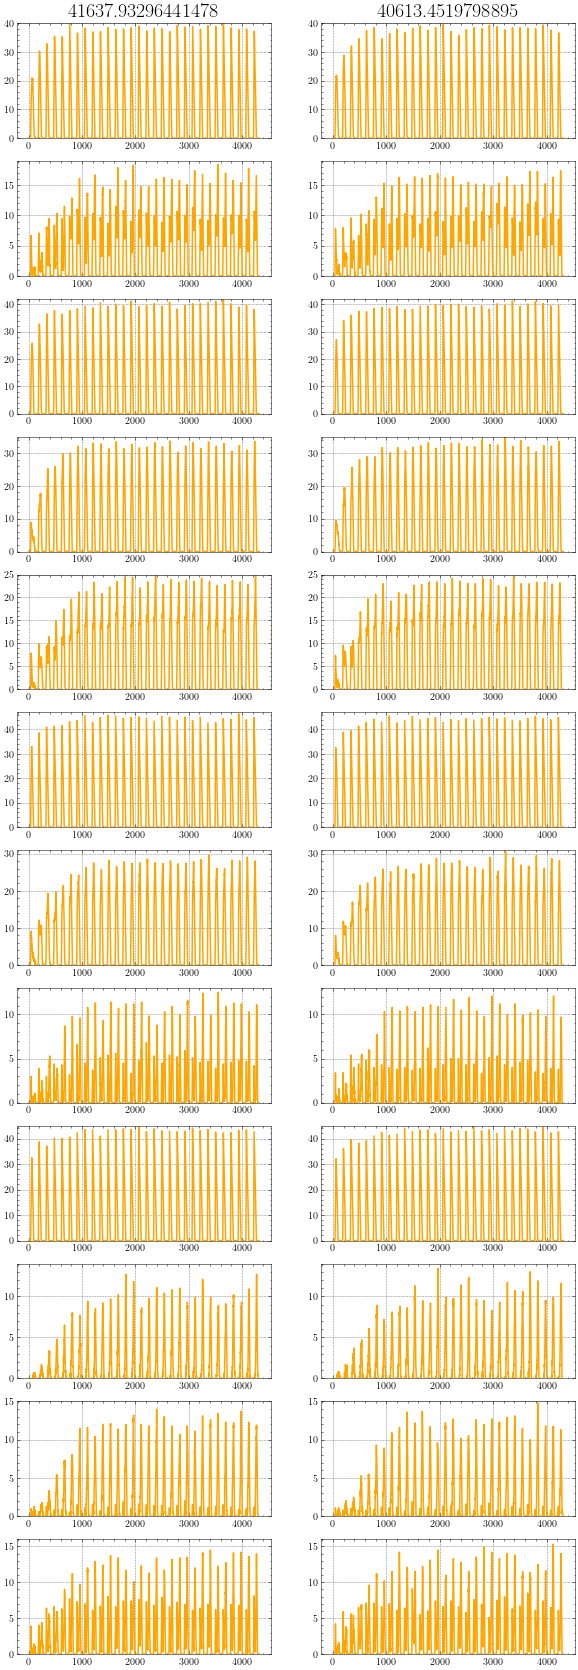

In [101]:
fig, ax = plt.subplots(12,2,figsize=(10,30))

lineplot_df = pd.concat(storage_TS.values())
lineplot_df = lineplot_df[lineplot_df["variation"]==4]
lineplot_df.rename({"index":"timestep"})

titles = ["Weekly visits; No social","Weekly visits; Highly social","3-day visits; Highly social","3-day visits; No social",]

print("Plotting scenarios ",titles[0]," and ",titles[1])

to_plot_dict = {0:lineplot_df[lineplot_df["scenario"]==2].groupby(["timestep"]).mean() ,
                1: lineplot_df[lineplot_df["scenario"]==3].groupby(["timestep"]).mean() }
    
for i in range(12):
    sns.lineplot(ax=ax[i,0],data=to_plot_dict[0]["o%s"%(i+4)],dashes=False,linewidth=1.5,color='orange') 
    sns.lineplot(ax=ax[i,1],data=to_plot_dict[1]["o%s"%(i+4)],dashes=False,linewidth=1.5,color='orange') 
    
    for a in ax[i,:]:
        a.set_ylim([0,np.ceil( np.max([ np.max(to_plot_dict[0]["o%s"%(i+4)]) , np.max(to_plot_dict[1]["o%s"%(i+4)]) ]) )])
        
for i in range(2):
    ax[0,i].set_title(to_plot_dict[i].iloc[-1,2],fontsize=20)